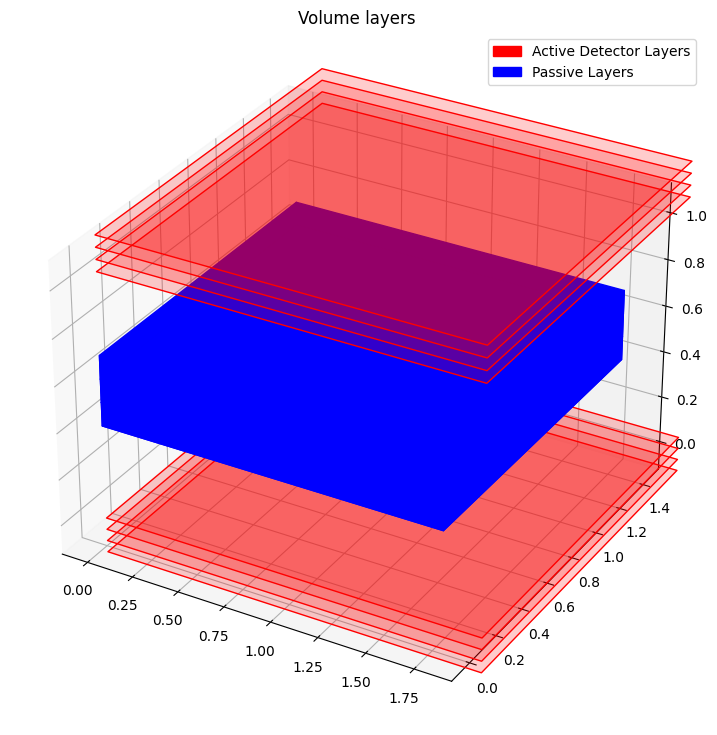

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import torch
from torch import Tensor, nn
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
DEVICE = torch.device('cpu')

# Volume
from tomopt.volume import PassiveLayer, PanelDetectorLayer, Volume, DetectorPanel

def get_layers():
    layers = []
    lwh = Tensor([1.8,1.4,1])
    size = 0.1
    init_eff = 0.9
    init_res = 1e4
    n_panels = 4
    layers.append(PanelDetectorLayer(pos='above', lw=lwh[:2], z=1.2, size=2*size,
                                     panels=[DetectorPanel(res=init_res, eff=init_eff,
                                                      init_xyz=[1,0.8,1.2-(i*(2*size)/n_panels)], init_xy_span=[2.0, 1.6],
                                                      device=DEVICE) for i in range(n_panels)]))
    # for z in [1.0,0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1]:
    for z in [0.7,0.6,0.5]:

        layers.append(PassiveLayer(lw=lwh[:2], z=z, size=size, device=DEVICE))
    layers.append(PanelDetectorLayer(pos='below', lw=lwh[:2], z=0.0, size=2*size,
                                     panels=[DetectorPanel(res=init_res, eff=init_eff,
                                                      init_xyz=[1,0.8,0.0-(i*(2*size)/n_panels)], init_xy_span=[2.0, 1.6],
                                                      device=DEVICE) for i in range(n_panels)]))

    return nn.ModuleList(layers)
    
volume = Volume(get_layers())

volume.draw(xlim=[-.1,1.5], ylim=[-.1,1.9], zlim=[-.1,1.1])

In [2]:
# Passive volume
from tomopt.core import X0
def arb_rad_length(*,z:float, lw:Tensor, size:float) -> Tensor:
    rad_length = torch.ones(list((lw/size).long()))*X0['air']

    if (z >= 0.0): 
        # T
        rad_length[1:6,12] = X0['iron']
        rad_length[3,11] = X0['iron']
        rad_length[3,10] = X0['iron']
        rad_length[3,9] = X0['iron']

        # O
        rad_length[7:10,11] = X0['iron']
        rad_length[7,10] = X0['iron']
        rad_length[9,10] = X0['iron']
        rad_length[7:10,9] = X0['iron']

        # M
        rad_length[11,9:12] = X0['iron']
        rad_length[12,11] = X0['iron']
        rad_length[13,10] = X0['iron']
        rad_length[14,11] = X0['iron']
        rad_length[15,9:12] = X0['iron']

        # O
        rad_length[2:5,7] = X0['iron']
        rad_length[1,4:7] = X0['iron']
        rad_length[5,4:7] = X0['iron']
        rad_length[2:5,3] = X0['iron']

        # p

        rad_length[7,1:5] = X0['iron']
        rad_length[7:10,5] = X0['iron']
        rad_length[8:10,3] = X0['iron']
        rad_length[9,4] = X0['iron']

        # t
        rad_length[11,3:7] = X0['iron']
        rad_length[12,5] = X0['iron']

    return rad_length

In [3]:
from typing import Tuple, List
from tomopt.inference.asr import VolumeInterest

def get_fig_size(preds: torch.Tensor,
                 nrows: int,
                 ncols: int=3,
                 dims: Tuple[int] = (0,1),
                 scale: float = 3.) -> Tuple[float]:
    
    """
    Compute matplotlib.pyplot.figure figsize, given the xy subplot ratio,
    the number of columns and rows, and the total number of subplots.
    
    INPUT:
    - VOI:VolumeInterest, an instance of the VolumeInterest class.
    - nrows:int, the number of rows.
    - ncols:int, the number of columns.
    - dims:Tuple[int], the VOI dimensions to consider, e.g dim=(0,1) XY plane,
    dim=(0,2) XZ plane dim=(1,2) YZ plane.
    - scale:float, scale factor of the figure, e.g figsize with scale=2 is twice as big as scale=1.
    """
    
    dx, dy = preds.shape[dims[0]], preds.shape[dims[1]]

    if dx>dy: 
        xy_ratio=[1.,float(dy/dx)]
    else: 
        xy_ratio=[float(dx/dy),1.]
        
    return (scale*ncols*(xy_ratio[0]+1/4),scale*nrows*(xy_ratio[1]+1/4))

def get_nrows(nplots: int,
              ncols: int) -> Tuple[int]:
    """
    Compute the number of columns of plt.subplots, given the total number of plots,
    the number of columns.
    
    INPUT:
     - nplots:int, the total number of plots.
     - ncols:int, the number of columns.
     
    OUTPUT:
     - nrows:int, the number of rows.
     - extra:int, the number of subplots left empty when nplots%ncols!=0.
    """
    
    if nplots%ncols==0:
        nrows, extra=int(nplots/ncols),0
    else:
        for i in range(1,ncols):
            if nplots%ncols==i: nrows, extra=int(nplots/ncols)+1,ncols-i
    return nrows, extra

def plot_voi_pred_by_voi_slice(preds: np.ndarray,
                               VOI: VolumeInterest,
                               dim: int = 0,
                               ncols: int = 4,
                               filename: str = None,
                               axis_label_all: bool = False,
                               scale: float = 4., 
                               colorbar_label: str = "scattering density [a.u]") -> None:

    """
    Plots scattering density prediction as 2D histograms, for each slice of the VOI
    along a the given dimension.
    
    Arguments:
    
    - pred:torch.tensor with size (nz,nx,ny,1) containing the score of each voxel, with ni the number of voxels along i.
    - VOI:VolumeInterest, an instance of the volume of interest.
    - dim:int=2, the dimension to consider. dim=0: z, dim=1: x, dim=2: y. If dim=2, predictions
      are represented as a 2D histogram in x and y for each VOI slice along z.
    - ncols:int=4, the number of columns of the figure.
    - filename:str=None, if filename is not None, figure save the figure as "filename".
    - axis_label_all:bool=False. If True, axis labels are shown on every subplot.
    """
    # set fontsize
    font = {'weight' : 'normal',
            'size'   : 10}
    
    import matplotlib
    matplotlib.rc('font', **font)
    
    # color map
    cmap = "viridis_r"
    
    # get # plots
    nplots = preds.shape[dim]
    
    if dim==0: dim_xy, dim_label, min_value = (1,2), ["x", "y","z"], VOI.voxel_edges[0, 0, 0, 0, 2].item()
    elif dim==1: dim_xy, dim_label, min_value = (0,2), ["y", "z", "x"], VOI.voxel_edges[0, 0, 0, 0, 0].item()
    else: dim_xy, dim_label, min_value = (0,1), ["x", "z", "y"], VOI.voxel_edges[0, 0, 0, 0, 1].item()
    
    # compute nrows given ncols
    # extra the number of blank plots (if nplots%ncols!=0)
    nrows, extra = get_nrows(nplots=nplots,
                             ncols=ncols)
        
    # compute figure size
    figsize = get_fig_size(preds=preds,
                           nrows=nrows,
                           ncols=ncols,
                           dims=dim_xy,
                           scale=scale)
        
    fig, axs = plt.subplots(ncols=ncols,
                            nrows=nrows,
                            figsize=figsize,
                            sharex=True,
                            sharey=True)
    
    axs = axs.ravel()
    
    # fig title
    fig.suptitle("Scattering density predictions, pixel size = {:.0f} mm".format(1000 * VOI.dxyz[0] / preds.shape[2]), y = 1.0)

    # compute min and max value for colorscale
    vmin, vmax = np.min(preds), np.max(preds)
    
    # Loop ober the number of voxels along `dim` dimension
    for i in range(nplots):
        if dim==2:
            preds_slice = preds[:,:,i]
        elif dim==1: 
            preds_slice = preds[:,i]
        else: 
            preds_slice = preds[i]

        im = axs[i].imshow(preds_slice.T, origin='lower', vmin=vmin, vmax=vmax, cmap=cmap)        
        axs[i].set_aspect("equal")
        axs[i].set_title("{} $\in$ [{:.2f},{:.2f}] m".format(dim_label[2], min_value + (i * VOI.vox_width), min_value + ((i+1) * VOI.vox_width)))

        # set axes x label 
        if (i%ncols==0) | (i==0) | axis_label_all:
            axs[i].set_ylabel("{} [mm]".format(dim_label[1]))
        # set axes y label    
        if (i>=nplots-ncols) | axis_label_all:
            axs[i].set_xlabel("{} [mm]".format(dim_label[0]))
    
    # remove empty axis 
    for i in range(1,extra+1):
        axs[-i].remove()
        axs[-i] = None
        
    # Add color bar
    cbar_ax = fig.add_axes([1.01, 0.15, 0.05, 0.7])
    fig.colorbar(im, cax=cbar_ax,label=colorbar_label)
    
    # save
    if filename is not None: fig.savefig(filename, bbox_inches = "tight")
    # plt.tight_layout()
    plt.show()



# <h1><center>Angle Statistic Reconstruction</center></h1>

The Angle Statistic Reconstruction (ASR) algorithm is used for reconstruction of the material density inside the volume from the muon scattering information. The current implementation `AngleStatisticReconstruction(AbsVolumeInferrer)`, adapted from [*Algorithm Angle Statistics Reconstruction: a robust reconstruction algorithm for Muon Scattering Tomography*](https://www.hep.phy.cam.ac.uk/~hommels/CosmicConcrete_dir/MuonPapersForBart/Paper_JINST_2014_AWE_alternativereco.pdf), is an alternantive to the default radiation length estimation algorithm implemented in `PanelX0Inferrer(AbsX0Inferrer(AbsVolumeInferrer))`.

Unlike the latter, ASR does not compute a voxel-wise estimate of the radiation length. Instead, it provides a voxel-wise prediction of the scattering density, given the scattering angle values of muon traversing the voxels. 

The algorithms proceeds as follow:

**Setup**
 - Define a grid of voxel in the sample volume.
 - Choose a muon-wise score $s$ to apply to each voxel. By default, the scattering angle $\Delta\theta$. If an estimate of the muon momentum $p$ is available, $s$ can be $\Delta\theta\times p$.
 - Choose a function $f$ to compute the final voxel score $S_{final}$ from the muon-wise prediction $s$.
 - For each voxel $j$:
     - Generate an empty list $S_j  = [\:]$.

**Scan**
 - For each muon:
     - Fit incoming and outgoing tracks.
     - Compute the scattering angle $\Delta\theta$.
     - Identify the set of voxels $V$ traversed by both the incoming and outgoing track.
     - For each voxel $j$ in $V$, assign a score $s$ to $S_j$.

**At the end of the scan**
 - For each voxel $j$, compute the final score $S_{final, j} = f(S_j)$.

## I - Volume of interest class

ASR requires a voxelized volume. Unlike in optimization mode, the voxelization can be different from the passive volume one. The custom voxelization is defined using the `VolumeInterest` class.

In [4]:
from tomopt.inference.asr import VolumeInterest
voi = VolumeInterest(position = [.9,0.7,0.5], # the center of the volume in meters
                     dimension = [1.8,1.4,0.3], # the x,y,z span of the volume in meters
                     voxel_width = 0.1) # the voxel size in meters

voi.n_vox_xyz

tensor([18, 14,  3], dtype=torch.int32)

## II - ASR parameters callback


Unlike the `PanelX0Inferrer` class, ASR requires several arguments when instanciated. It is done by using the `ParamsASR` callback and providing the following arguments:

 - `voi:VolumeInterest`: The voxelized volume.

 - `score_method`: The function $f$ which computes the final voxel scattering density $S_{final}$ as a fonction of the muon-wise voxel scores $S$, such that $S_{final} = f\left( S \right)$. By default, it is simply the median of the voxel score distribution.

 - `dtheta_range`: Muons with scattering angle outside of `dtheta_range` will be rejected.

 - `use_p`: If `True`, the muon-wise scores $x_i$ are computed as $S = p \times d\theta$. If False, $S = d\theta$


In [5]:
from tomopt.optimisation.callbacks.asr_callbacks import ParamsASR
from functools import partial
import math

asr_params = ParamsASR(voi = voi, 
                       score_method = partial(np.quantile,q=.5),
                       dtheta_range = (0., math.pi/4), 
                       use_p = True)


In [5]:
from tomopt.inference.asr import AngleStatisticReconstruction
from tomopt.optimisation import PanelVolumeWrapper, VoxelX0Loss

wrapper = PanelVolumeWrapper(volume,
                             xy_pos_opt=partial(torch.optim.SGD, lr=5e4),
                             z_pos_opt=partial(torch.optim.SGD, lr=5e3),
                             xy_span_opt=partial(torch.optim.SGD, lr=5e3),
                             partial_volume_inferrer = AngleStatisticReconstruction,
                             loss_func=VoxelX0Loss(target_budget=20, cost_coef=None))

from tomopt.optimisation import PredHandler, MuonResampler

In [7]:
from tomopt.optimisation.data import PassiveYielder
preds = wrapper.predict(PassiveYielder([arb_rad_length]), 
                        n_mu_per_volume=100000, 
                        mu_bs=500, 
                        pred_cb=PredHandler(),
                        cbs=[MuonResampler(), asr_params])


Sub-volumes



Voxel triggering



Assigning voxels score


Compute final score


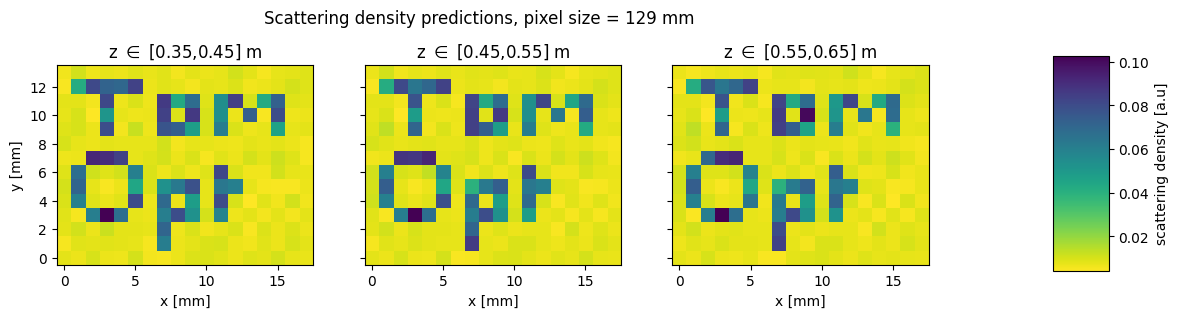

In [8]:
plot_voi_pred_by_voi_slice(preds = preds[0][0],
                           VOI = voi,
                           dim = 0,
                           ncols = 3, scale=3)

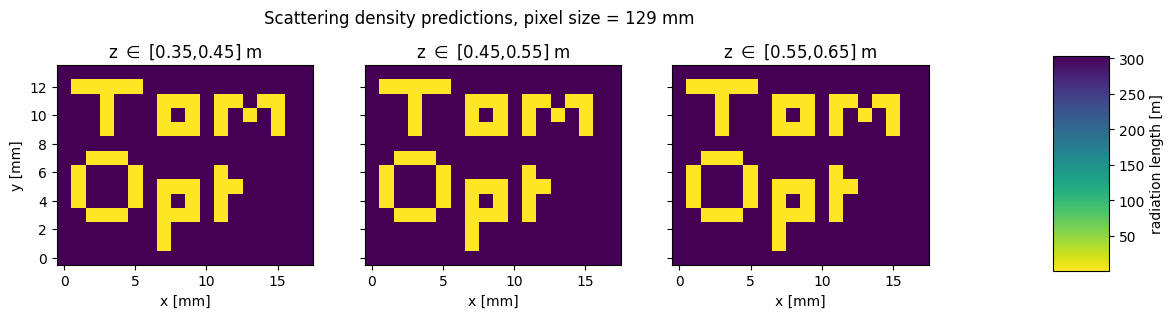

In [9]:
true = wrapper.volume.get_rad_cube().detach().numpy()

plot_voi_pred_by_voi_slice(preds = true,
                            VOI = voi,
                            dim =0,
                            ncols = 3, 
                            scale = 3, 
                            colorbar_label = "radiation length [m]")

## III - ASR - POCA comparision

In [8]:
wrapper = PanelVolumeWrapper(volume,
                             xy_pos_opt=partial(torch.optim.SGD, lr=5e4),
                             z_pos_opt=partial(torch.optim.SGD, lr=5e3),
                             xy_span_opt=partial(torch.optim.SGD, lr=1e4),
                             loss_func=VoxelX0Loss(target_budget=20, cost_coef=None))

from tomopt.optimisation import PredHandler
from tomopt.optimisation.data import PassiveYielder 
preds_poca = wrapper.predict(PassiveYielder([arb_rad_length]), 
                        n_mu_per_volume=10000, 
                        mu_bs=500, 
                        pred_cb=PredHandler(),
                        cbs=[MuonResampler()])

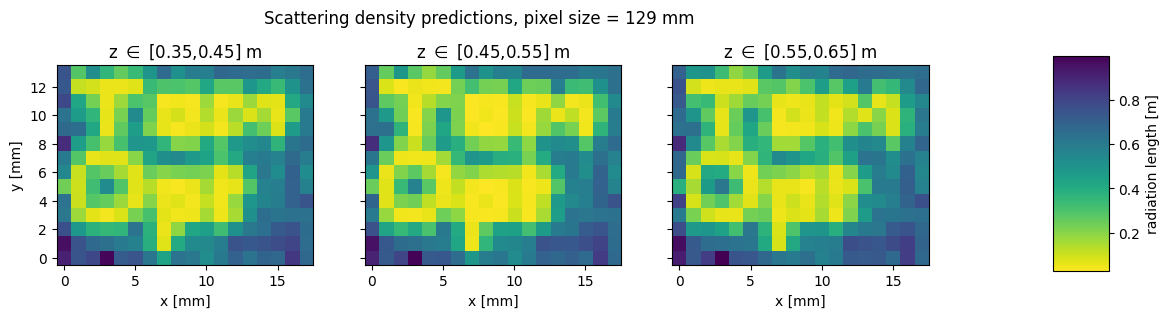

In [10]:
plot_voi_pred_by_voi_slice(preds = preds_poca[0][0],
                            VOI = voi,
                            dim =0,
                            ncols = 3, 
                            scale = 3, 
                            colorbar_label = "radiation length [m]")